# Processes and how to use them

Processes in Nengo can be used to describe
general functions or dynamical systems,
including those with randomness.
They can be useful if you want a `Node` output
that has a state (like a dynamical system),
and they're also used for things like
injecting noise into Ensembles
so that you can not only have "white" noise
that samples from a distribution,
but can also have "colored" noise
where subsequent samples are correlated with past samples.

This notebook will first present the basic process interface,
then demonstrate some of the built-in Nengo processes
and how they can be used in your code.
It will also describe how to create your own custom process.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import nengo

## Interface

We will begin by looking at how to run an existing process instance.

The key functions for running processes
are `run`, `run_steps`, and `apply`.
The first two are for running without an input,
and the third is for applying the process to an input.

There are also two helper functions,
`trange` and `ntrange`,
which return the time points corresponding to a process output,
given either a length of time or a number of steps, respectively.

### `run`: running a process for a length of time

The `run` function runs a process
for a given length of time, without any input.
Many of the random processes in `nengo.processes` will be run this way,
since they do not require an input signal.

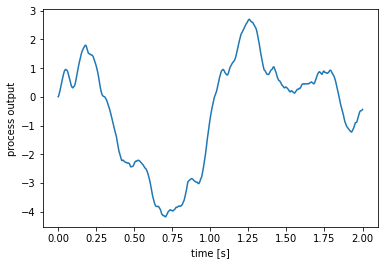

In [2]:
# Create a process (details on the FilteredNoise process below)
process = nengo.processes.FilteredNoise(
    synapse=nengo.synapses.Alpha(0.1), seed=0)

# run the process for two seconds
y = process.run(2.0)

# get a corresponding two-second time range
t = process.trange(2.0)

plt.figure()
plt.plot(t, y)
plt.xlabel('time [s]')
plt.ylabel('process output');

### `run_steps`: running a process for a number of steps

To run the process for a number of steps, use the `run_steps` function.
The length of the generated signal will depend on the process's `default_dt`.

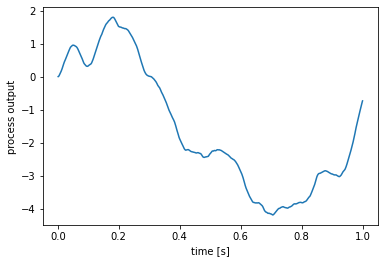

In [3]:
process = nengo.processes.FilteredNoise(
    synapse=nengo.synapses.Alpha(0.1), seed=0)

# run the process for 1000 steps
y = process.run_steps(1000)

# get a corresponding 1000-step time range
t = process.ntrange(1000)

plt.figure()
plt.plot(t, y)
plt.xlabel('time [s]')
plt.ylabel('process output');

### `apply`: running a process with an input

To run a process with an input, use the `apply` function.

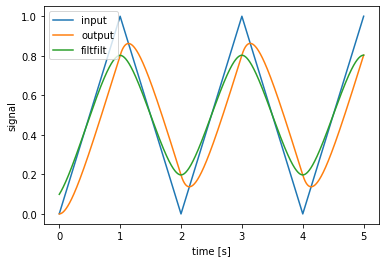

In [4]:
process = nengo.synapses.Lowpass(0.2)

t = process.trange(5)
x = np.minimum(t % 2, 2 - (t % 2))  # sawtooth wave
y = process.apply(x)  # general to all Processes
z = process.filtfilt(x)  # specific to Synapses

plt.figure()
plt.plot(t, x, label='input')
plt.plot(t, y, label='output')
plt.plot(t, z, label='filtfilt')
plt.xlabel('time [s]')
plt.ylabel('signal')
plt.legend();

Note that Synapses are a special kind of process,
and have the additional functions `filt` and `filtfilt`.
`filt` works mostly the same as `apply`,
but with some additional functionality
such as the ability to filter along any axis.
`filtfilt` provides zero-phase filtering.

### Changing the time-step (`dt` and `default_dt`)

To run a process with a different time-step,
you can either pass the new time step (`dt`) when calling the functions,
or change the `default_dt` property of the process.

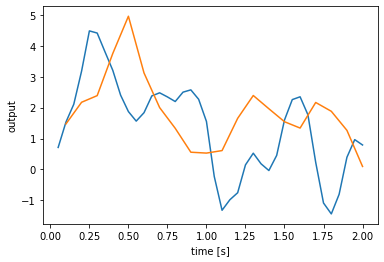

In [5]:
process = nengo.processes.FilteredNoise(
    synapse=nengo.synapses.Alpha(0.1), seed=0)
y1 = process.run(2.0, dt=0.05)
t1 = process.trange(2.0, dt=0.05)

process = nengo.processes.FilteredNoise(
    synapse=nengo.synapses.Alpha(0.1), default_dt=0.1, seed=0)
y2 = process.run(2.0)
t2 = process.trange(2.0)

plt.figure()
plt.plot(t1, y1, label='dt = %s' % 0.05)
plt.plot(t2, y2, label='dt = %s' % 0.1)
plt.xlabel('time [s]')
plt.ylabel('output');

## `WhiteSignal`

The `WhiteSignal` process is used to generate band-limited white noise,
with only frequencies below a given cutoff frequency.

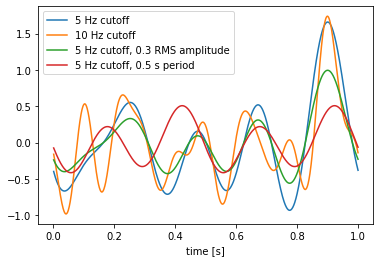

In [6]:
with nengo.Network() as model:
    a = nengo.Node(nengo.processes.WhiteSignal(1.0, high=5, seed=0))
    b = nengo.Node(nengo.processes.WhiteSignal(1.0, high=10, seed=0))
    c = nengo.Node(nengo.processes.WhiteSignal(1.0, high=5, rms=0.3, seed=0))
    d = nengo.Node(nengo.processes.WhiteSignal(0.5, high=5, seed=0))
    ap = nengo.Probe(a)
    bp = nengo.Probe(b)
    cp = nengo.Probe(c)
    dp = nengo.Probe(d)

with nengo.Simulator(model) as sim:
    sim.run(1.0)

plt.figure()
plt.plot(sim.trange(), sim.data[ap], label='5 Hz cutoff')
plt.plot(sim.trange(), sim.data[bp], label='10 Hz cutoff')
plt.plot(sim.trange(), sim.data[cp], label='5 Hz cutoff, 0.3 RMS amplitude')
plt.plot(sim.trange(), sim.data[dp], label='5 Hz cutoff, 0.5 s period')
plt.xlabel("time [s]")
plt.legend(loc=2);

Note that the 10 Hz signal (green)
has similar low frequency characteristics
as the 5 Hz signal (blue),
but with additional higher-frequency components.
The 0.3 RMS amplitude 5 Hz signal (red)
is the same as the original 5 Hz signal (blue),
but scaled down (the default RMS amplitude is 0.5).
Finally, the signal with a 0.5 s period
(instead of a 1 s period like the others)
is completely different,
because changing the period changes
the spacing of the random frequency components
and thus creates a completely different signal.
Note how the signal with the 0.5 s period repeats itself;
for example, the value at $t = 0$
is the same as the value at $t = 0.5$,
and the value at $t = 0.4$
is the same as the value at $t = 0.9$.

## `WhiteNoise`

The `WhiteNoise` process generates white noise,
with equal power across all frequencies.
By default, it is scaled so that the integral process (Brownian noise)
will have the same standard deviation regardless of `dt`.

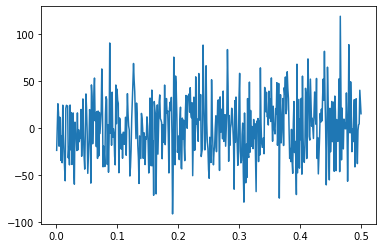

In [7]:
process = nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(0, 1))

t = process.trange(0.5)
y = process.run(0.5)
plt.figure()
plt.plot(t, y);

One use of the `WhiteNoise` process
is to inject noise into neural populations.
Here, we create two identical ensembles,
but add a bit of noise to one and no noise to the other.
We plot the membrane voltages of both.

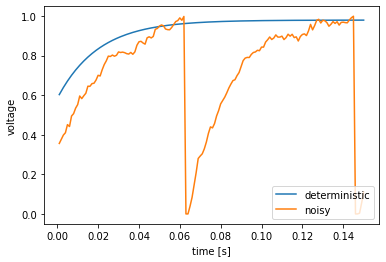

In [8]:
process = nengo.processes.WhiteNoise(
    dist=nengo.dists.Gaussian(0, 0.01), seed=1)

with nengo.Network() as model:
    ens_args = dict(encoders=[[1]], intercepts=[0.01], max_rates=[100])
    a = nengo.Ensemble(1, 1, **ens_args)
    b = nengo.Ensemble(1, 1, noise=process, **ens_args)
    a_voltage = nengo.Probe(a.neurons, 'voltage')
    b_voltage = nengo.Probe(b.neurons, 'voltage')

with nengo.Simulator(model) as sim:
    sim.run(0.15)

plt.figure()
plt.plot(sim.trange(), sim.data[a_voltage], label="deterministic")
plt.plot(sim.trange(), sim.data[b_voltage], label="noisy")
plt.xlabel('time [s]')
plt.ylabel('voltage')
plt.legend(loc=4);

We see that the neuron without noise (blue)
approaches its firing threshold,
but never quite gets there.
Adding a bit of noise (green)
causes the neuron to occasionally jitter above the threshold,
resulting in two spikes
(where the voltage suddenly drops to zero).

## `FilteredNoise`

The `FilteredNoise` process takes a white noise signal
and passes it through a filter.
Using any type of lowpass filter (e.g. `Lowpass`, `Alpha`)
will result in a signal similar to `WhiteSignal`,
but rather than being ideally filtered
(i.e. no frequency content above the cutoff),
the `FilteredNoise` signal
will have some frequency content above the cutoff,
with the amount depending on the filter used.
Here, we can see how an `Alpha` filter
(a second-order lowpass filter)
is much better than the `Lowpass` filter
(a first-order lowpass filter)
at removing the high-frequency content.

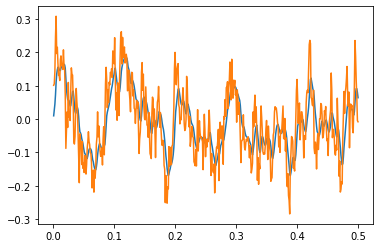

In [9]:
process1 = nengo.processes.FilteredNoise(
    dist=nengo.dists.Gaussian(0, 0.01), synapse=nengo.Alpha(0.005), seed=0)

process2 = nengo.processes.FilteredNoise(
    dist=nengo.dists.Gaussian(0, 0.01), synapse=nengo.Lowpass(0.005), seed=0)

tlen = 0.5
plt.figure()
plt.plot(process1.trange(tlen), process1.run(tlen))
plt.plot(process2.trange(tlen), process2.run(tlen));

The `FilteredNoise` process with an `Alpha` synapse (blue)
has significantly lower high-frequency components
than a similar process with a `Lowpass` synapse (green).

## `PresentInput`

The `PresentInput` process is useful for
presenting a series of static inputs to a network,
where each input is shown for the same length of time.
Once all the images have been shown,
they repeat from the beginning.
One application is presenting a series of images to a classification network.

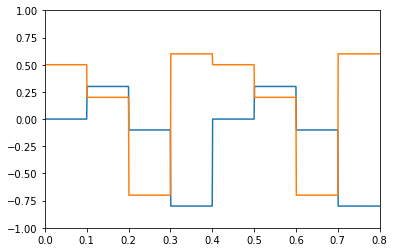

In [10]:
inputs = [[0, 0.5], [0.3, 0.2], [-0.1, -0.7], [-0.8, 0.6]]
process = nengo.processes.PresentInput(inputs, presentation_time=0.1)

tlen = 0.8
plt.figure()
plt.plot(process.trange(tlen), process.run(tlen))
plt.xlim([0, tlen])
plt.ylim([-1, 1]);

## Custom processes

You can create custom processes
by inheriting from the `nengo.Process` class
and overloading the `make_step` and `make_state` methods.

As an example, we'll make a simple custom process
that implements a two-dimensional oscillator dynamical system.
The `make_state` function defines a `state` variable
to store the state.
The `make_step` function uses that state
and a fixed `A` matrix to determine
how the state changes over time.

One advantage to using a process over a simple function
is that if we reset our simulator,
`make_step` will be called again
and the process state
will be restored to the initial state.

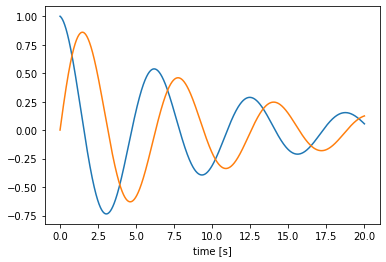

In [11]:
class SimpleOscillator(nengo.Process):
    def make_state(self, shape_in, shape_out, dt, dtype=None):
        # return a dictionary mapping strings to their initial state
        return {"state": np.array([1., 0.])}

    def make_step(self, shape_in, shape_out, dt, rng, state):
        A = np.array([[-0.1, -1.], [1., -0.1]])
        s = state["state"]

        # define the step function, which will be called
        # by the node every time step
        def step(t):
            s[:] += dt * np.dot(A, s)
            return s

        return step  # return the step function


with nengo.Network() as model:
    a = nengo.Node(SimpleOscillator(), size_in=0, size_out=2)
    a_p = nengo.Probe(a)

with nengo.Simulator(model) as sim:
    sim.run(20.0)

plt.figure()
plt.plot(sim.trange(), sim.data[a_p])
plt.xlabel('time [s]');

We can generalize this process to one
that can implement arbitrary linear dynamical systems,
given `A` and `B` matrices.
We will overload the `__init__` method
to take and store these matrices,
as well as check the matrix shapes
and set the default size in and out.
The advantage of using the default sizes
is that when we then create a node using the process,
or run the process using `apply`,
we do not need to specify the sizes.

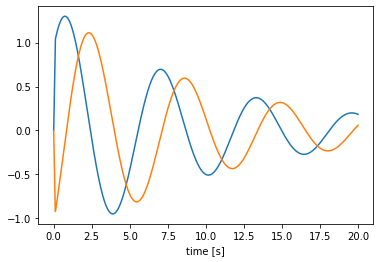

In [12]:
class LTIProcess(nengo.Process):
    def __init__(self, A, B, **kwargs):
        A, B = np.asarray(A), np.asarray(B)

        # check that the matrix shapes are compatible
        assert A.ndim == 2 and A.shape[0] == A.shape[1]
        assert B.ndim == 2 and B.shape[0] == A.shape[0]

        # store the matrices for `make_step`
        self.A = A
        self.B = B

        # pass the default sizes to the Process constructor
        super().__init__(
            default_size_in=B.shape[1], default_size_out=A.shape[0], **kwargs)

    def make_state(self, shape_in, shape_out, dt, dtype=None):
        return {"state": np.zeros(self.A.shape[0])}

    def make_step(self, shape_in, shape_out, dt, rng, state):
        assert shape_in == (self.B.shape[1],)
        assert shape_out == (self.A.shape[0],)
        A, B = self.A, self.B
        s = state["state"]

        def step(t, x):
            s[:] += dt * (np.dot(A, s) + np.dot(B, x))
            return s

        return step


# demonstrate the LTIProcess in action
A = [[-0.1, -1], [1, -0.1]]
B = [[10], [-10]]

with nengo.Network() as model:
    u = nengo.Node(lambda t: 1 if t < 0.1 else 0)
    # we don't need to specify size_in and size_out!
    a = nengo.Node(LTIProcess(A, B))
    nengo.Connection(u, a)
    a_p = nengo.Probe(a)

with nengo.Simulator(model) as sim:
    sim.run(20.0)

plt.figure()
plt.plot(sim.trange(), sim.data[a_p])
plt.xlabel('time [s]');